# Laser pulse propagation in optical fiber

This notebook shows a simple, scalar implementation of the finite difference <a href="#1">[1]</a> for solving the Nonlinear Schrödinger Equation <a href="#2">[2]</a>.

$\frac{\partial A}{\partial z}=-\frac{\alpha}{2}A+i \frac{\beta_2}{2} \frac{\partial^2 A}{\partial t^2}-i \gamma(|A|^2A)$

This nonlinear partial differential equation models how the envelope and phase of light pulse changes when propagating through a single mode optical fiber, when taking power attenuation ($\alpha$), group velocity dispersion ($\beta_2$)and waveguide nonlinearity ($\gamma$) causing self-phase modulation (SPM) into account. A is the slowly varying amplitude of the pulse envelope and t is measured in a frame of reference moving with the pulse at the group velocity $v_g$. The nonlinear Schrödinger equation (for optics) can be derived from the wave equation. However we can choose between two (Fourier transform) notations. The derivation with the negative one can be found in Ursula Keller's book <a href="#3">[3]</a>. I used this, because the scipy library uses the negative convention for the DFT. Depending on the initial width $T_0$ and the peak power $P_0$ of the incident pulse, either dispersive or non linear
effects may dominate along the fiber. It is useful to introduce two length scales, known as the dispersion length $L_D$ and the nonlinear length $L_{NL}$. Let us consider a time scale normalized to the input width $T_0$ as:

$\tau=\frac{t}{T_0}$

In addition, we introduce a normalized amplitude U as:

$A(z,\tau)=\sqrt{P_0}e^{\frac{- \alpha Z}{2}}U(z,\tau)$

We now take into consideration a space scale normalized to the fiber length as:

$\zeta=\frac{z}{L}$

Where L is the fiber length. Thus, it turns out that $U(\zeta,\tau)$ satisfies

$\frac{\partial U}{\partial \zeta}=+i \frac{L}{2 L_D} sgn(\beta_2) \frac{\partial^2 U}{\partial \tau^2}-i e^{- \alpha Z \zeta} \frac{L}{L_{NL}} (|U|^2 U)$

Where $sgn(\beta_2)=\pm 1$ depending on the sign of the coefficient $\beta_2$ and

$L_D=\frac{T_0 ^ 2}{|\beta_2|}$

$L_{NL}=\frac{1}{\gamma_0 P_0}$

The concept behind this normalization process is to exclude any kind of overflow error that may occur during solving the PDE with finite difference method. The derivation of the dimensionless transformation for the nonlinear Schrödinger equation can be found here <a href="#4">[4]</a>. The plotting functions originally came from here <a href="#5">[5]</a>.

## References

<div id="1">[1] Wikimedia Foundation. (2024, November 28). Finite difference method. Wikipedia. https://en.wikipedia.org/wiki Finite_difference_method</div>
<div id="2">[2] Wikimedia Foundation. (2024, November 21). Nonlinear Schrödinger equation. Wikipedia. https://en.wikipedia.org/wiki/Nonlinear_Schr%C3%B6dinger_equation</div>
<div id="3">[3] Keller, U. (2023). Ultrafast lasers: A comprehensive introduction to fundamental principles with practical applications. Springer International Publishing.</div>
<div id="4">[4] Felice, D. (2016, December 1). A Study of a Nonlinear Schrödinger Equation for Optical Fibers. arxiv. https://arxiv.org/pdf/1612.00358</div>
<div id="5">[5] Krarup, O. (n.d.). OLEKRARUP123/NLSE-vector-solver: Code for modelling the nonlinear Schrödinger equation for optical fiber pulse propagation. GitHub. https://github.com/OleKrarup123/NLSE-vector-solver</div>

## Importing the modules

In [1]:
from libraries import *
from variables import *
from functions import *
from classes import *

## Initialize class about simulation parameters

In [2]:
sim_config = SIM_config(N,Time_window,duration,wavelength0,theta,chirp)

## Testing the defined functions

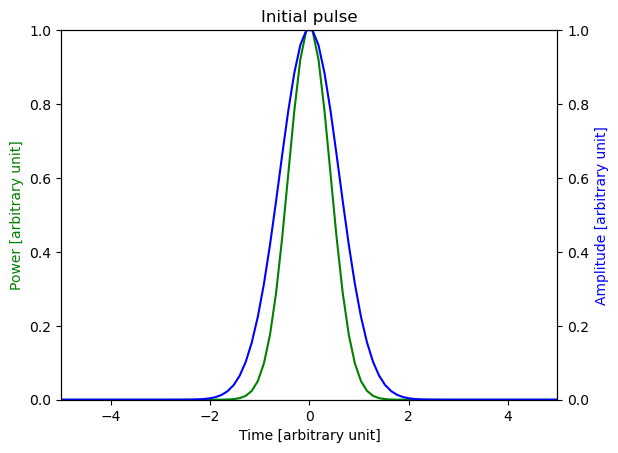

In [3]:
# Initialize Gaussian pulse in the time domain
testPulse = GaussianPulseTime(sim_config.t,amplitude,sim_config.duration) / amplitude

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
plt.title("Initial pulse")
ax1.plot(sim_config.t,getPower(testPulse)/np.max(getPower(testPulse)),'g-')
ax2.plot(sim_config.t,abs(testPulse)/np.max(abs(testPulse)),'b-')
ax1.set_xlabel("Time [arbitrary unit]")
ax1.set_ylabel("Power [arbitrary unit]", color='g')
ax2.set_ylabel("Amplitude [arbitrary unit]", color='b')
ax1.set_ylim(0,1)
ax2.set_ylim(0,1)
plt.xlim(-5*sim_config.duration,5*sim_config.duration)
savePlot('initial pulse')
plt.show()

## Testing the defined spectrum functions

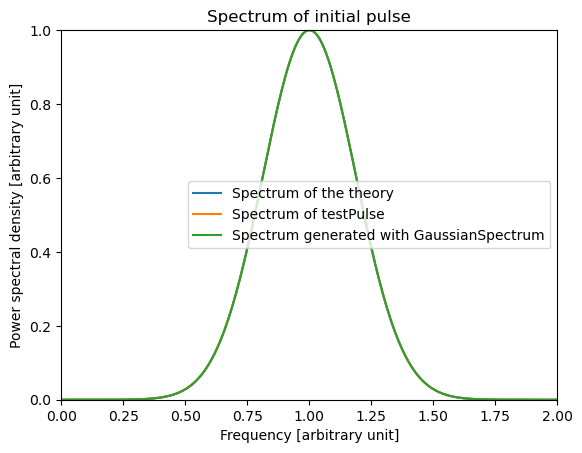

In [4]:
# Initialize Gaussian pulse in the frequency domain
testSpectrumTheory = GaussianPulseFrequency(sim_config.f,sim_config.frequency0,amplitude,sim_config.duration)
# Getting spectrum from pulse
testSpectrum=getSpectrumFromPulse(sim_config.t,sim_config.f,testPulse)
# Getting Gaussian spectrum
testSpectrum_2=GaussianSpectrum(sim_config.t,sim_config.f,amplitude,1/(sim_config.duration))
plt.figure()
plt.title("Spectrum of initial pulse")
plt.plot(sim_config.f,getPower(testSpectrumTheory)/np.max(getPower(testSpectrumTheory)),label="Spectrum of the theory")
plt.plot(sim_config.f_rel,getPower(testSpectrum)/np.max(getPower(testSpectrum)),label="Spectrum of testPulse")
plt.plot(sim_config.f_rel,getPower(testSpectrum_2)/np.max(getPower(testSpectrum_2)),label="Spectrum generated with GaussianSpectrum")
plt.axis([-1 + sim_config.frequency0,1 + sim_config.frequency0,0,1])
plt.xlabel("Frequency [arbitrary unit]")
plt.ylabel("Power spectral density [arbitrary unit]")
plt.legend()
savePlot('spectrum of the initial pulse')
plt.show()

## Testing the FWHM function

In [5]:
# Something is odd with the product of the pulse and the spectrum's FWHM
FWHM_frequency=FWHM(sim_config.f,getPower(testSpectrum))
FWHM_time=FWHM(sim_config.t,getPower(testPulse))
product=FWHM_frequency*FWHM_time
print(f"The product of the pulse and the spectrum's FWHM is {product}")
print(f"The dispersion length is {dispersion_length} m")
print(f"The nonlinear length is {nonlinear_length} m")

The product of the pulse and the spectrum's FWHM is 0.4296875000000193
The dispersion length is 1.7699115044247788e-06 m
The nonlinear length is 1.0493827160493829e+17 m


## Initialize class about fiber

In [6]:
#fiber=Fiber_config(nsteps,Length,nonlinear_length,dispersion_length,alpha_dB_per_m)
fiber=Fiber_config(nsteps,Length,nonlinear_length,dispersion_length,alpha_dB_per_km)

# Run Simulation

In [7]:
%%script false
pulseMatrix, spectrumMatrix = Simulation(fiber,sim_config,testPulse,'EFORK3')
testPulse0=np.copy(pulseMatrix[0,:])
testSpectrum0=np.copy(spectrumMatrix[0,:])
testPulseFinal=np.copy(pulseMatrix[-1,:])
testSpectrumFinal=np.copy(spectrumMatrix[-1,:])

Couldn't find program: 'false'


## Initialize functions for plotting the results

In [8]:
%%script false
FWHM_time_final=FWHM(sim_config.t,getPower(testPulseFinal))
FWHM_frequency_final=FWHM(sim_config.f_rel,getPower(testSpectrumFinal))
print("FWHM_time_final",FWHM_time_final)
print("FWHM_frequency_final",FWHM_frequency_final)
plotFirstAndLastPulse(pulseMatrix,sim_config)
plotPulseMatrix2D(pulseMatrix,fiber,sim_config)
plotFirstAndLastSpectrum(spectrumMatrix,sim_config,FWHM_frequency_final)
plotSpectrumMatrix2D(spectrumMatrix,fiber,sim_config,FWHM_frequency_final)
plotSpectrogram(sim_config, pulseMatrix[0,:], 50, 2000, sim_config.time_step, label='initial')
plotSpectrogram(sim_config, pulseMatrix[-1,:], 50, 2000, sim_config.time_step, label='final')

Couldn't find program: 'false'


## Fractional order between 0.1 and 0.1

In [9]:
%%script false
alphas = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
t=sim_config.t
plt.figure()
power = getPower(testPulse)
maximum_power=np.max(power)
plt.plot(t,power/maximum_power,label="Initial pulse")
myfile = open('results.txt', 'w')
for element in alphas:
    sim_config = SIM_config(N,Time_window,frequency0,wavelength0,element)
    pulseMatrix, spectrumMatrix = Simulation(fiber,sim_config,testPulse,'EFORK3')
    plt.plot(t,getPower(pulseMatrix[-1,:])/maximum_power,label=f"Fractional order: {element}")
    testPulseFinal=np.copy(pulseMatrix[-1,:])
    testSpectrumFinal=np.copy(spectrumMatrix[-1,:])
    FWHM_time_final=FWHM(sim_config.t,getPower(testPulseFinal))
    FWHM_frequency_final=FWHM(sim_config.f_rel,getPower(testSpectrumFinal))
    FW5percentM_time_final = FW5percentM(sim_config.t,getPower(testPulseFinal))
    FW5percentM_frequency_final=FW5percentM(sim_config.f_rel,getPower(testSpectrumFinal))
    FW95percentM_time_final = FW95percentM(sim_config.t,getPower(testPulseFinal))
    FW95percentM_frequency_final=FW95percentM(sim_config.f_rel,getPower(testSpectrumFinal))
    myfile.write(f"{element},{FWHM_time_final},{FWHM_frequency_final},{FW5percentM_time_final},{FW5percentM_frequency_final},{FW95percentM_time_final},{FW95percentM_frequency_final}\n")
myfile.close()
plt.title("Fractional order between 0.1 and 0.9")
plt.axis([-8,8,0,1])
plt.xlabel("Time [arbitrary unit]")
plt.ylabel("Power [arbitrary unit]")
#savePlot('Fractional order between 0.1 and 0.9')
plt.legend(bbox_to_anchor=(1.05,0.3))
plt.show()

Couldn't find program: 'false'


## Checking how reducing the number of steps affects pulse accuracy

In [10]:
%%script false

#First, make a copy of the pulse computed with the original fiber settings and nsteps
baselinePulse = np.copy(testPulseFinal) # reference with 2**14 steps 

#Make array of the number of steps
#nsteps_list=np.logspace(0,np.log10(fiber.nsteps),9)  
nsteps_list=[2**13, 2**14, 2**15]
      
#Pre-define arrays for holding errors
err_list=np.zeros_like(nsteps_list)*1.0

#Start figure and plot the pulse with the large number of steps
plt.figure()
plt.plot(sim_config.t,getPower(baselinePulse)/np.max(getPower(baselinePulse)),label=f"Baseline for nsteps = {fiber.nsteps}")

#For each iteration, define a new fiber with a different number of steps but the same physical properties
for i in range(0,len(nsteps_list)):
  nsteps_i=int(nsteps_list[i])
  fiber_i=Fiber_config(nsteps_i,Length,nonlinear_length,dispersion_length,alpha_dB_per_km)
  
  #Run the simulation and plot the computed pulse
  pulseMatrix_i,_= Simulation(fiber_i,sim_config,testPulse,'EFORK3')
  
  pulse_i=pulseMatrix_i[-1,:]
  
  plt.plot(sim_config.t,getPower(pulse_i)/np.max(getPower(pulse_i)),label=f"Pulse for nsteps = {nsteps_i}")
  
  #Compute and store errors
  err = getEnergy(sim_config.t,(pulse_i-baselinePulse))/getEnergy(sim_config.t, baselinePulse)*100
  err_list[i]=err

plt.xlabel("Time [a.u.]")
plt.ylabel("Power [a.u.]")
plt.title("Impulse solutions for different nsteps with EFORK3 method")
plt.legend(bbox_to_anchor=(1.05,0.3))
plt.show()

Couldn't find program: 'false'


## Convergence of the solution

In [11]:
%%script false

x=np.log10(nsteps_list)
y=np.log10(err_list/np.max(err_list))

model = np.polyfit(x, y, 1)
print("Model parameters [a,b]=",model)
y_model=np.poly1d(model)
plt.figure()
plt.plot(x,y_model(x),'r-',label=f"$err(1 step)*nsteps^{  {np.round(model[0],3)}}$")
plt.plot(x,y,'.')
plt.xlabel('log10(nsteps)')
plt.ylabel('log10(err/err_max)')
plt.title("Converfence of the solution with EFORK3 method")
plt.legend()
plt.show()

Couldn't find program: 'false'


## Chirped Gaussian pulse for GVD term only

In [12]:
%%script false
chirp_parameters = [-2, 0, 2]
normalized_zlocs_array = np.linspace(0,fiber.length,fiber.nsteps) / fiber.dispersion_length
plt.figure()
for m in chirp_parameters:
    sim_config = SIM_config(N,Time_window,duration,wavelength0,theta,m)
    fiber = Fiber_config(nsteps,Length,nonlinear_length,dispersion_length,alpha_dB_per_km)
    testPulse = chirpedGaussianPulseTime(sim_config.t,amplitude,sim_config.duration,sim_config.chirp) / amplitude
    pulseMatrix, _ = Simulation(fiber,sim_config,testPulse,'EFORK3')
    testPulse0 = np.copy(pulseMatrix[0,:])
    FWHM_testPulse0 = FWHM(sim_config.t,getPower(testPulse0)/np.max(getPower(testPulse0)))
    broadening_factor_simulation = np.zeros(fiber.nsteps)
    for n in range(fiber.nsteps):
        testPulse_index = np.copy(pulseMatrix[n,:])
        FWHM_testPulse_index = FWHM(sim_config.t,getPower(testPulse_index)/np.max(getPower(testPulse_index)))
        broadening_factor_simulation[n] = FWHM_testPulse_index / FWHM_testPulse0
    plt.plot(normalized_zlocs_array,broadening_factor_simulation,'.',label=f"Chirp parameter = {m}")
plt.xlabel('z/L_D')
plt.ylabel('Broadening factor')
plt.title("Broadening factor vs. normalized propagation distance for different chirp parameters")
plt.axis([0,0.05,0,5])
plt.legend()
plt.show()

Couldn't find program: 'false'


## Chirped Gaussian pulse for SPM term only

1 % ready
2 % ready
3 % ready
4 % ready
5 % ready
6 % ready
7 % ready
8 % ready
9 % ready
10 % ready
11 % ready
12 % ready
13 % ready
14 % ready
15 % ready
16 % ready
17 % ready
18 % ready
19 % ready
20 % ready
21 % ready
22 % ready
23 % ready
24 % ready
25 % ready
26 % ready
27 % ready
28 % ready
29 % ready
30 % ready
31 % ready
32 % ready
33 % ready
34 % ready
35 % ready
36 % ready
37 % ready
38 % ready
39 % ready
40 % ready
41 % ready
42 % ready
43 % ready
44 % ready
45 % ready
46 % ready
47 % ready
48 % ready
49 % ready
50 % ready
51 % ready
52 % ready
53 % ready
54 % ready
55 % ready
56 % ready
57 % ready
58 % ready
59 % ready
60 % ready
61 % ready
62 % ready
63 % ready
64 % ready
65 % ready
66 % ready
67 % ready
68 % ready
69 % ready
70 % ready
71 % ready
72 % ready
73 % ready
74 % ready
75 % ready
76 % ready
77 % ready
78 % ready
79 % ready
80 % ready
81 % ready
82 % ready
83 % ready
84 % ready
85 % ready
86 % ready
87 % ready
88 % ready
89 % ready
90 % ready
91 % ready
92 % rea

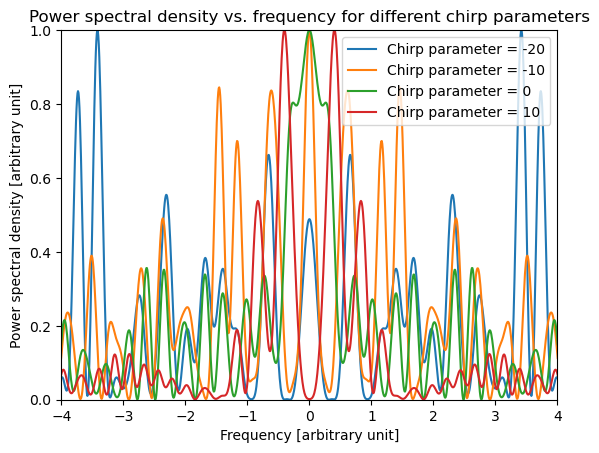

In [13]:
#%%script false
chirp_parameters = [-20, -10, 0, 10]
fiber_length = 4.5 * np.pi * nonlinear_length
plt.figure()
for m in chirp_parameters:
    sim_config = SIM_config(N,Time_window,duration,wavelength0,theta,m)
    fiber = Fiber_config(nsteps,fiber_length,nonlinear_length,dispersion_length,0)
    testPulse = chirpedGaussianPulseTime(sim_config.t,amplitude,sim_config.duration,sim_config.chirp) / amplitude
    _, spectrumMatrix = Simulation(fiber,sim_config,testPulse,'EFORK3')
    power = getPower(spectrumMatrix[-1,:])
    maximum_power=np.max(power)
    plt.plot(sim_config.f,power/maximum_power,'-',label=f"Chirp parameter = {m}")
plt.xlabel("Frequency [arbitrary unit]")
plt.ylabel("Power spectral density [arbitrary unit]")
plt.title("Power spectral density vs. frequency for different chirp parameters")
plt.axis([-4,4,0,1])
plt.legend()
plt.show()